1.2255762815475464
Best model found
Pruning at epoch 1, Err: 1.23, Sparsity: 0.00
1.0712531805038452
Best model found
Pruning at epoch 2, Err: 1.07, Sparsity: 0.10
1.0482910871505737
Best model found
Pruning at epoch 3, Err: 1.05, Sparsity: 0.20
1.0430357456207275
Best model found
Pruning at epoch 4, Err: 1.04, Sparsity: 0.30
1.0457484722137451
Best model found
Pruning at epoch 5, Err: 1.05, Sparsity: 0.39
1.0457665920257568
Best model found
Pruning at epoch 6, Err: 1.05, Sparsity: 0.48
1.062856674194336
Best model found
Pruning at epoch 7, Err: 1.06, Sparsity: 0.56
1.0541154146194458
Best model found
Pruning at epoch 8, Err: 1.05, Sparsity: 0.63
1.0750706195831299
Best model found
Pruning at epoch 9, Err: 1.08, Sparsity: 0.69
1.0676560401916504
Best model found
Pruning at epoch 10, Err: 1.07, Sparsity: 0.75
1.0768195390701294
Best model found
Pruning at epoch 11, Err: 1.08, Sparsity: 0.80
1.1529031991958618
Best model found
Pruning at epoch 12, Err: 1.15, Sparsity: 0.84
1.389402985572

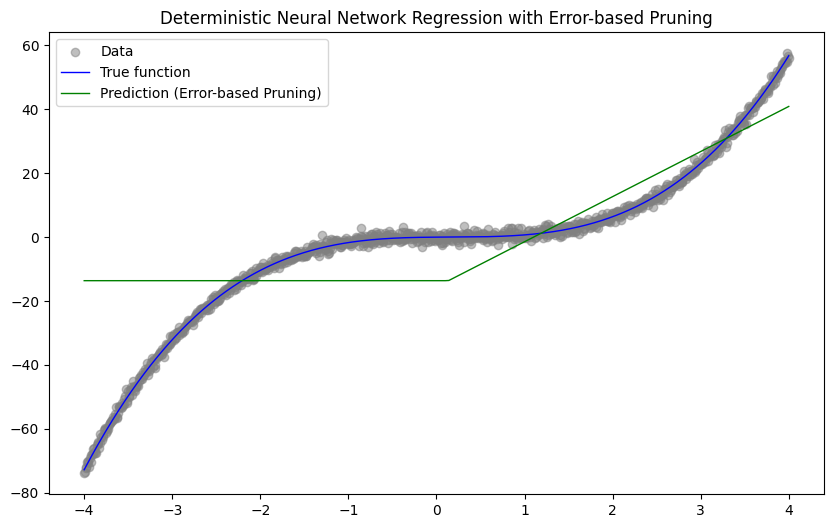

In [2]:
import torch.nn.utils.prune as prune
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal, kl_divergence
# Generate synthetic data for polynomial regression
torch.manual_seed(0)
N = 1  # Input dimension
num_data = 1000
x = torch.linspace(-4, 4, num_data).unsqueeze(1)  # Shape (num_data, N)
# True function: y = x^3 - 0.5 x^2 + 0.2 x + noise
y_true = x**3 - 0.5 * x**2 + 0.2 * x
y = y_true + 1 * torch.randn_like(x)  # Add noise


# Define a deterministic network
class PrunableNet(nn.Module):
    def __init__(self):
        super(PrunableNet, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Pruning function
def apply_pruning(model, pruning_rate):
    """
    Apply pruning to all prunable layers in the model.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):  # Apply pruning only to Linear layers
            prune.l1_unstructured(module, name='weight', amount=pruning_rate)

# Remove pruning reparameterization (optional after final pruning)
def remove_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.remove(module, 'weight')

def get_sparsity(model):
    """
    Compute the sparsity of the model.
    """
    total = 0
    zeros = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            total += module.weight.nelement()
            zeros += torch.sum(module.weight == 0).item()
    return zeros / total

# Instantiate model, optimizer, and define training loop
prunable_model = PrunableNet()
optimizer = optim.Adam(prunable_model.parameters(), lr=0.01)

# Training loop with error-based pruning
num_epochs = 100
pruning_rate = 0.1  # Initial pruning rate
max_err_threshold = 200  # Loss threshold for pruning
pruning_rate_increment = 0.01  # Increment for pruning rate after each pruning step

current_pruning_rate = pruning_rate

for epoch in range(num_epochs):

    for _ in range(1000):
        prunable_model.train()
        optimizer.zero_grad()
        
        y_pred = prunable_model(x)
        loss = F.mse_loss(y_pred, y, reduction='sum')  # Sum over data points
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 200 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}')

    error = F.mse_loss(prunable_model(x), y, reduction='mean').item()
    print(error)
    # Monitor error and apply pruning if loss exceeds threshold
    if error < max_err_threshold:
        try:
            import copy
            torch.save(prunable_model.state_dict(), f"best_model_{epoch}.pth")
            print("Best model found")
        except Exception as e:
            print(e)
        
        print(f'Pruning at epoch {epoch+1}, Err: {error:.2f}, Sparsity: {get_sparsity(prunable_model):.2f}')
        apply_pruning(prunable_model, current_pruning_rate)
        current_pruning_rate += pruning_rate_increment  # Increase pruning rate for next step
        current_pruning_rate = min(current_pruning_rate, 1.0)  # Ensure pruning rate does not exceed 1.0
    else:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}')
        break

# Remove pruning reparameterization after training (optional)
remove_pruning(prunable_model)

# Plot the results after pruning
prunable_model.eval()
with torch.no_grad():
    x_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_test_pred = prunable_model(x_test).squeeze().numpy()  # Generate predictions

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x.numpy(), y_true.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_test_pred, label='Prediction (Error-based Pruning)', linewidth=1, color='green')
plt.title("Deterministic Neural Network Regression with Error-based Pruning")
plt.legend()
plt.show()


In [3]:
# Pruned Weight 복원 함수
def restore_pruned_weights_as_state_dict(state_dict):
    restored_state_dict = state_dict.copy()  # 원본 state_dict 복사

    for key in list(state_dict.keys()):
        if key.endswith(".weight_orig"):
            # 레이어 이름 추출 (e.g., 'linear1' from 'linear1.weight_orig')
            layer_name = key.rsplit(".", 1)[0]
            
            # weight_orig과 weight_mask 가져오기
            weight_orig = state_dict[f"{layer_name}.weight_orig"]
            weight_mask = state_dict[f"{layer_name}.weight_mask"]

            # Pruned Weight 계산
            pruned_weight = weight_orig * weight_mask

            # state_dict 업데이트
            restored_state_dict[f"{layer_name}.weight"] = pruned_weight

            # weight_orig과 weight_mask 제거
            del restored_state_dict[f"{layer_name}.weight_orig"]
            del restored_state_dict[f"{layer_name}.weight_mask"]

    return restored_state_dict

modelMLE = PrunableNet()
print(f"The number of Params: {sum(p.numel() for p in modelMLE.parameters())}")
best_weight = torch.load('best_model_15.pth')
modelMLE.load_state_dict(restore_pruned_weights_as_state_dict(best_weight))
print(get_sparsity(modelMLE))

The number of Params: 301
0.94


/var/folders/c8/4q9v7htn6fb6n_gdxh3rs8gh0000gn/T/ipykernel_62694/3725677160.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_weight = torch.load('best_model_15.pth'

Final Error: 4.44, Sparisty: 0.94
Essential Parameters (non-zero): 18


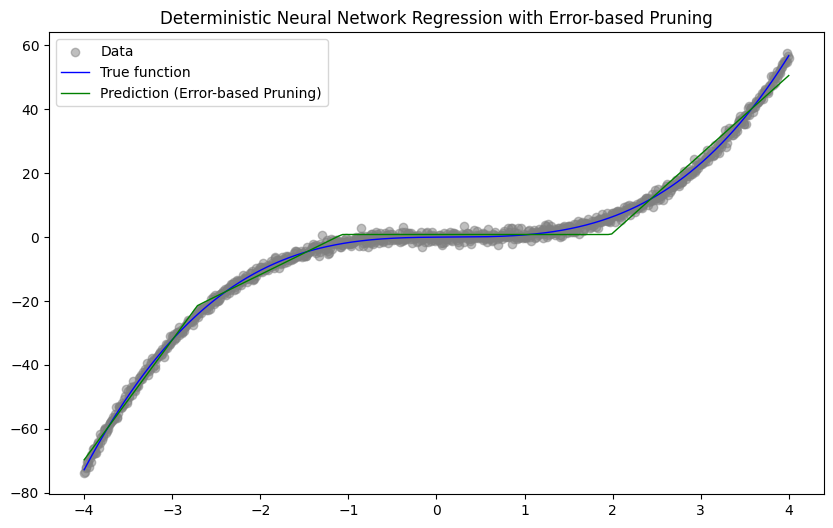

In [4]:

# Plot the results after pruning
modelMLE.eval()
with torch.no_grad():
    x_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_test_pred = modelMLE(x_test).squeeze().numpy()  # Generate predictions

error = F.mse_loss(modelMLE(x), y, reduction='mean').item()
print(f'Final Error: {error:.2f}, Sparisty: {get_sparsity(modelMLE):.2f}')
print(f"Essential Parameters (non-zero): {int((1-get_sparsity(modelMLE)) * sum(p.numel() for p in modelMLE.parameters()))}")
plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x.numpy(), y_true.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_test_pred, label='Prediction (Error-based Pruning)', linewidth=1, color='green')
plt.title("Deterministic Neural Network Regression with Error-based Pruning")
plt.legend()
plt.show()


In [5]:

# Define a Bayesian Linear Layer with spike-and-slab prior
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_pi=0.5, prior_mu1 = 0.0, prior_sigma1=1.0, prior_sigma2=0.0001):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Variational parameters for weights
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.1, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-1, -1))
        
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.1, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-1, -1))

        # Prior parameters
        self.prior_mu = torch.zeros_like(self.weight_mu.flatten()) * prior_mu1
        self.prior_sigma = torch.ones_like(self.weight_mu.flatten()) * prior_sigma1

        self.prior_mu_bias = torch.zeros_like(self.bias_mu) 
        self.prior_sigma_bias = torch.ones_like(self.bias_mu)
        
    def forward(self, input):
        # Sample epsilon for weights and biases using rsample
        self.weight_sigma = torch.log1p(torch.exp(self.weight_rho))  # Softplus to ensure positivity

        self.weight_dist = Normal(self.weight_mu, self.weight_sigma)
        self.bias_dist = Normal(self.bias_mu, torch.log1p(torch.exp(self.bias_rho)))

        # Use rsample for reparameterization trick
        weight = self.weight_dist.rsample()
        bias = self.bias_dist.rsample()

        kld = kl_divergence(self.weight_dist, Normal(self.prior_mu, self.prior_sigma)).mean()
        kld += kl_divergence(self.bias_dist, Normal(self.prior_mu_bias, self.prior_sigma_bias)).mean()
        # Linear forward pass
        return F.linear(input, weight, bias), kld / 2

# Define the Bayesian Neural Network
class BayesianNet(nn.Module):
    def __init__(self, prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1):
        super(BayesianNet, self).__init__()
        self.blinear1 = BayesianLinear(1, 100, 1, prior_mu1=0, prior_sigma1 = prior_sigma1, prior_sigma2=0.00001)
        self.blinear2 = BayesianLinear(100, 1, 1, prior_mu1=0, prior_sigma1 = prior_sigma1, prior_sigma2=0.00001)

    def forward(self, x):

        kld = 0

        x, kl = self.blinear1(x)
        kld += kl

        x = F.relu(x)

        x, kl = self.blinear2(x)
        kld += kl

        return x, kld

In [6]:
import re
from glob import glob

# 파일 리스트 가져오기
weights_list = glob('*.pth')

# 숫자 기준으로 정렬
weights_list.sort(key=lambda x: int(re.search(r'\d+', x).group()))

print(weights_list)


['best_model_0.pth', 'best_model_1.pth', 'best_model_2.pth', 'best_model_3.pth', 'best_model_4.pth', 'best_model_5.pth', 'best_model_6.pth', 'best_model_7.pth', 'best_model_8.pth', 'best_model_9.pth', 'best_model_10.pth', 'best_model_11.pth', 'best_model_12.pth', 'best_model_13.pth', 'best_model_14.pth', 'best_model_15.pth']


The number of Params: 301
0.0


/var/folders/c8/4q9v7htn6fb6n_gdxh3rs8gh0000gn/T/ipykernel_62694/3683614164.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_weight = torch.load(path)
/var/folders/c

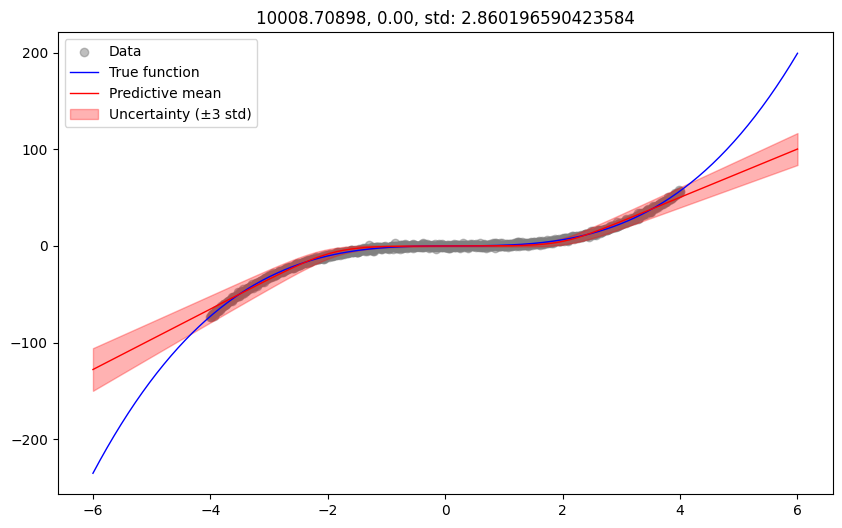

The number of Params: 301
0.1


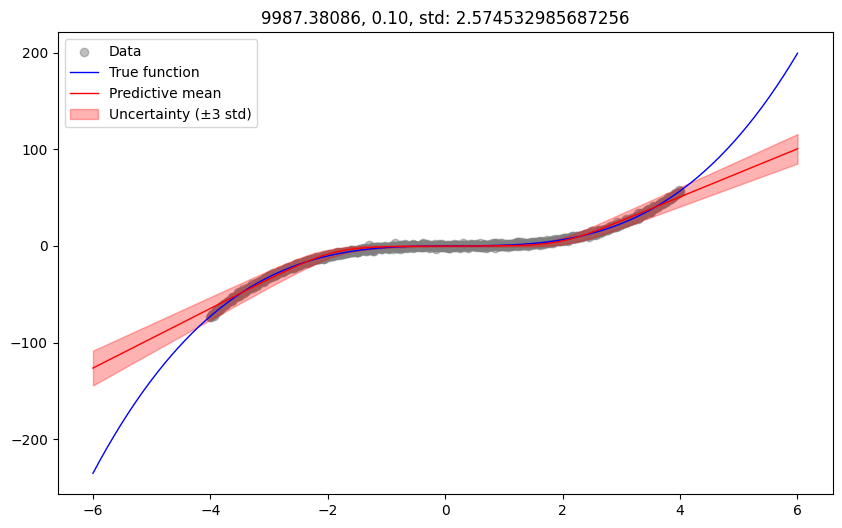

The number of Params: 301
0.2


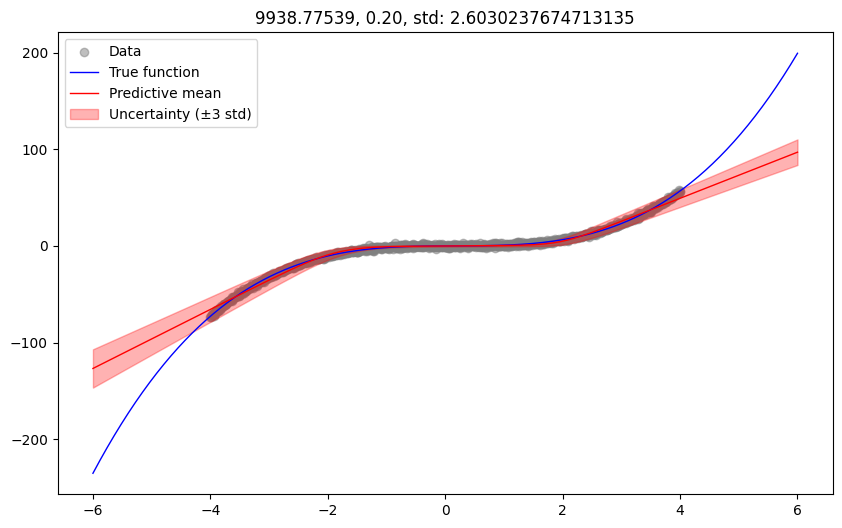

The number of Params: 301
0.3


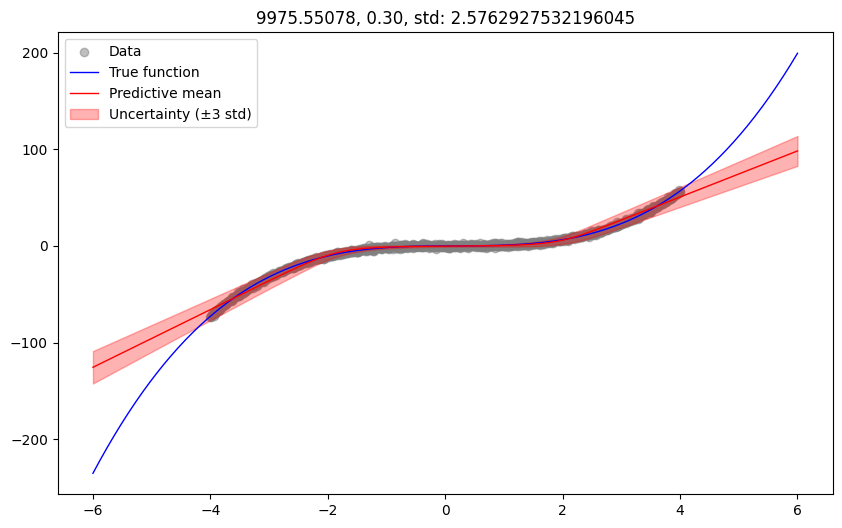

The number of Params: 301
0.39


In [ ]:


for path in weights_list:
    modelMLE = PrunableNet()
    print(f"The number of Params: {sum(p.numel() for p in modelMLE.parameters())}")
    best_weight = torch.load(path)
    modelMLE.load_state_dict(restore_pruned_weights_as_state_dict(best_weight))
    print(get_sparsity(modelMLE))

    weights = modelMLE.linear1.weight.data.clone()
    loc1 = weights.flatten() # 모든 가중치를 1차원 텐서로 정리
    loc1_bias = modelMLE.linear1.bias.data.clone()
    scale1 = torch.where(loc1 == 0, torch.full_like(loc1, 1e-3), torch.ones_like(loc1))

    weights = modelMLE.linear2.weight.data.clone()
    loc2 = weights.flatten() # 모든 가중치를 1차원 텐서로 정리
    loc2_bias = modelMLE.linear2.bias.data.clone()
    scale2 = torch.where(loc2 == 0, torch.full_like(loc2, 1e-3), torch.ones_like(loc2))

    # Instantiate the model and optimizer
    model = BayesianNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.blinear1.prior_mu = loc1.detach().clone()
    model.blinear1.prior_sigma = scale1.detach().clone()

    model.blinear2.prior_mu = loc2.detach().clone()
    model.blinear2.prior_sigma = scale2.detach().clone()


    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        y_pred, kld = model(x)
        nll = F.mse_loss(y_pred, y, reduction='mean')  # Sum over data points
        loss = nll + kld / len(x)
        loss.backward()
        optimizer.step()
        
        # if (epoch + 1) % 200 == 0:
        #     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}, NLL: {nll.item():.2f}, KL: {kld.item():.2f}')

    # Plot the# Plot the results
    model.eval()
    with torch.no_grad():
        x_test = torch.linspace(-6, 6, 200).unsqueeze(1)
        y_test = x_test**3 - 0.5 * x_test**2 + 0.2 * x_test
        y_preds = []
        for _ in range(100):  # Sample multiple times to get uncertainty estimates
            y_sample = model(x_test)[0].squeeze().numpy()  # Generate predictions
            y_preds.append(y_sample)
        
        y_preds = np.array(y_preds)  # Shape: (100, 200) (samples, data points)
        y_mean = y_preds.mean(axis=0)  # Predictive mean
        y_std = y_preds.std(axis=0)  # Predictive standard deviation


    error = F.mse_loss(torch.tensor(y_mean), y_test, reduction='mean').item()

    plt.figure(figsize=(10, 6))
    plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
    plt.plot(x_test.numpy(), y_test.numpy(), label='True function', linewidth=1, color='blue')
    plt.plot(x_test.numpy(), y_mean, label='Predictive mean', linewidth=1, color='red')
    plt.fill_between(x_test.squeeze().numpy(), 
                    y_mean - 3 * y_std, 
                    y_mean + 3 * y_std, 
                    color='red', alpha=0.3, label='Uncertainty (±3 std)')
    plt.title(f"{error:.5f}, {get_sparsity(modelMLE):.2f}, std: {y_std.mean()}")
    plt.legend()
    plt.show()

# Error


Epoch 200/10000, Loss: 508.07, NLL: 508.06, KL: 1.44
Epoch 400/10000, Loss: 566.57, NLL: 566.57, KL: 1.47
Epoch 600/10000, Loss: 338.60, NLL: 338.60, KL: 1.51
Epoch 800/10000, Loss: 242.62, NLL: 242.62, KL: 1.55
Epoch 1000/10000, Loss: 148.96, NLL: 148.96, KL: 1.58
Epoch 1200/10000, Loss: 129.09, NLL: 129.09, KL: 1.60
Epoch 1400/10000, Loss: 112.80, NLL: 112.80, KL: 1.61
Epoch 1600/10000, Loss: 127.42, NLL: 127.42, KL: 1.63
Epoch 1800/10000, Loss: 134.60, NLL: 134.60, KL: 1.65
Epoch 2000/10000, Loss: 96.31, NLL: 96.31, KL: 1.67
Epoch 2200/10000, Loss: 99.09, NLL: 99.09, KL: 1.70
Epoch 2400/10000, Loss: 88.56, NLL: 88.56, KL: 1.73
Epoch 2600/10000, Loss: 87.77, NLL: 87.77, KL: 1.77
Epoch 2800/10000, Loss: 100.03, NLL: 100.03, KL: 1.81
Epoch 3000/10000, Loss: 67.00, NLL: 67.00, KL: 1.85
Epoch 3200/10000, Loss: 51.46, NLL: 51.46, KL: 1.91
Epoch 3400/10000, Loss: 61.39, NLL: 61.39, KL: 1.96
Epoch 3600/10000, Loss: 54.09, NLL: 54.09, KL: 2.00
Epoch 3800/10000, Loss: 39.23, NLL: 39.23, KL: 2

/var/folders/c8/4q9v7htn6fb6n_gdxh3rs8gh0000gn/T/ipykernel_62542/3913223725.py:42: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error = F.mse_loss(torch.tensor(y_mean), y_test, reduction='mean').item()


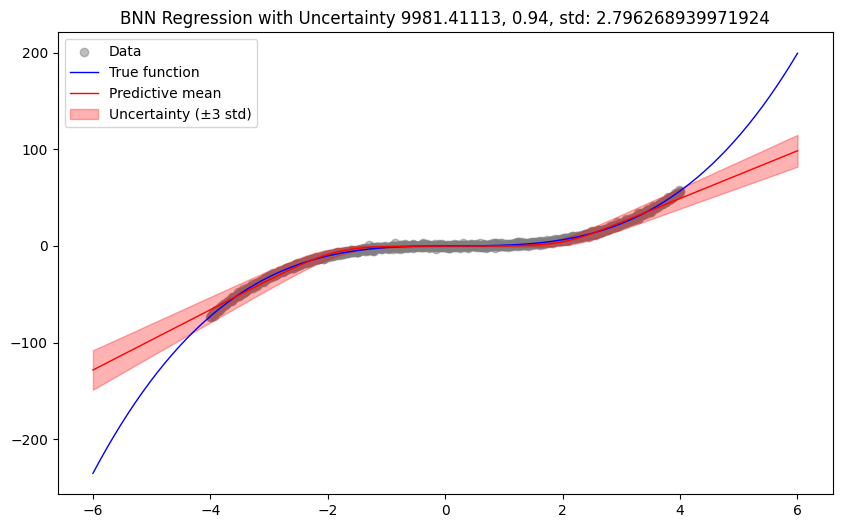

In [10]:

# Instantiate the model and optimizer
model = BayesianNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# model.blinear1.prior_mu = loc1.detach().clone()
# model.blinear1.prior_sigma = scale1.detach().clone()

# model.blinear2.prior_mu = loc2.detach().clone()
# model.blinear2.prior_sigma = scale2.detach().clone()


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred, kld = model(x)
    nll = F.mse_loss(y_pred, y, reduction='mean')  # Sum over data points
    loss = nll + kld / len(x)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}, NLL: {nll.item():.2f}, KL: {kld.item():.2f}')

# Plot the# Plot the results
model.eval()
with torch.no_grad():
    x_test = torch.linspace(-6, 6, 200).unsqueeze(1)
    y_test = x_test**3 - 0.5 * x_test**2 + 0.2 * x_test
    y_preds = []
    for _ in range(100):  # Sample multiple times to get uncertainty estimates
        y_sample = model(x_test)[0].squeeze().numpy()  # Generate predictions
        y_preds.append(y_sample)
    
    y_preds = np.array(y_preds)  # Shape: (100, 200) (samples, data points)
    y_mean = y_preds.mean(axis=0)  # Predictive mean
    y_std = y_preds.std(axis=0)  # Predictive standard deviation


error = F.mse_loss(torch.tensor(y_mean), y_test, reduction='mean').item()

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x_test.numpy(), y_test.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_mean, label='Predictive mean', linewidth=1, color='red')
plt.fill_between(x_test.squeeze().numpy(), 
                y_mean - 3 * y_std, 
                y_mean + 3 * y_std, 
                color='red', alpha=0.3, label='Uncertainty (±3 std)')
plt.title(f"BNN Regression with Uncertainty {error:.5f}, {get_sparsity(modelMLE):.2f}, std: {y_std.mean()}")
plt.legend()
plt.show()

# Error


NameError: name 'y_mean_0_01' is not defined

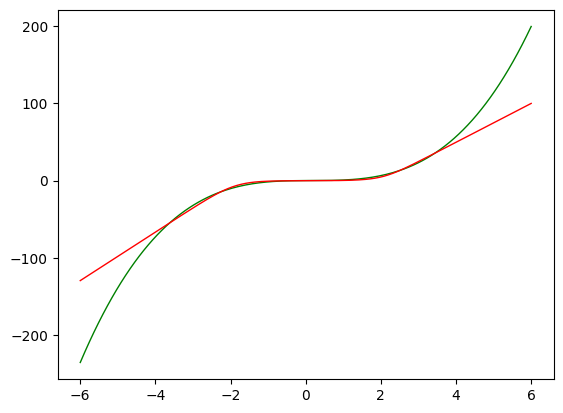

In [9]:
plt.plot(x_test.numpy(), y_test.numpy(), label='True function', linewidth=1, color='green')
plt.plot(x_test.numpy(), y_mean, label='Predictive mean', linewidth=1, color='red')
plt.plot(x_test.numpy(), y_mean_0_01, label='Predictive mean', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_mean_spar_50, label='Predictive mean', linewidth=1, color='black')
plt.plot(x_test.numpy(), y_mean_spar_1, label='Predictive mean', linewidth=1, color='purple')
